## Bayesian Neural Network with approximate optimization

**Objective:** Implement Bayesian approximate method to train Bayesian neural networks.



We estimate the posterior distribution of the weights in a two-layer Multilayer Perceptron (MLP) Bayesian Neural Network (BNN). Bayesian Neural Networks incorporate Bayesian probability principles, offering a probabilistic interpretation of model weights. This approach provides measures of uncertainty in the predictions, which can be crucial for decision-making processes in critical applications.

Consider a two-layer MLP with one hidden layer. The network performs a binary classification task on a dataset $D=\{(x_i,y_i)\}_{i=1}^N$, where $x_i$ is a feature vector, and $y_i$ is a binary label. Specifically, we use the Iris Dataset, which is provided in sklearn, and can be accessed as follows:

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Simplify the task to binary classification (e.g., Setosa vs. Versicolour)
# Exclude the third class (Virginica) from the dataset
binary_filter = y != 2
X_binary, y_binary = X[binary_filter], y[binary_filter]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

You can access it from sklearn, and transform to Torch Tensors for following implementations: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html.
The Iris dataset has Setosa, Versicolour, and Virginica. We simplify the problem to binary classification by excluding Virninica.

The Iris dataset has four features: sepal length, sepal width, petal length and petal width. We want to predict the type of Iris based on these four features.

Therefore, we have $y_i=0$ representing Setosa, $y_i=1$ representing Versicolour. We also have $x_i\in\mathbb{R}^4$, corresponding to the four features. We have the dataset $D = \{(x_1,y_1),(x_2,y_2),\dots,(x_N,y_N)\}$.

For the two-layer MLP should have one input layer and one output layer with a ReLU activation function and a binary output (e.g., using a sigmoid activation function for the output layer). We assume a prior distribution over the weights $W$ of the MLP to be isotropic Gaussian with mean $\mu$ zero and the variance as identity matrix, i.e., $W\sim(0, I)$, where $I$ is the identity matrix. 

**Problem 1.1**: Implement Laplace approximation for the problem above, assuming the prior as the isotropic Gaussian given above. We start by using a standard training to find 
$$W_{MAP}=\arg\min_{W} -\sum_{i=1}^N y_i\log(\sigma_s(\hat{y}_i))+(1-y_i)\log(1-\sigma_s(\hat{y}_i))+\frac{\alpha}{2}\|W\|_2^2$$
where $\sigma_s$ is the sigmoid function, and $\alpha$ is a hyperparameter determining the $L_2$ regularization. Pick $\alpha=1\mathrm{E}^{-1}$ at the beginning.

We now can approximate the posterior with $p(W|D)\sim\mathcal{N}(W_{MAP},(\alpha I - \nabla_W^2\log p(D|W))^{-1})$, where $\nabla_W^2 \log p(D|W)$ is the Hessian of log-likelyhood. Apply the Woodbury Inverse Lemma to compute the covariance of the posterior. You may find slide 18 of BNN Part II helpful.

As Laplace approximation is a Bayesian method, we can optimize the hyperparameter $\alpha$ by maximizing the marginal likelihood. As in slide 19 of lecture notes BNN Part II, we have $\alpha = \frac{\gamma}{\||W_{MAP}|\|_2^2}$, $\gamma = \sum_{i=1}^k\frac{\lambda_i}{\alpha + \lambda_i}$, with $\lambda_i$ being the i-th eigen value of $-\nabla_W^2\log p(D|\theta)$. Find the Bayesiannly optimal $\alpha$ and train for $p(W|D)$ again.

In [29]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize

class LaplaceApproximation:
    def __init__(self, alpha=1e-1):
        self.alpha = alpha
        self.W_map = None
        self.hessian = None
        self.posterior_covariance = None
        self.X = None
        self.y = None
        
    def sigmoid(self, x):
        return expit(x)
    
    def loss_function(self, W, X, y, alpha):
        N = X.shape[0]
        y_hat = self.sigmoid(np.dot(X, W))
        loss = -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) + 0.5 * alpha * np.linalg.norm(W)**2
        return loss
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        n_features = X.shape[1]
        
        # Initialize weights randomly
        initial_weights = np.random.randn(n_features)
        
        # Find MAP estimate of the weights
        result = minimize(self.loss_function, initial_weights, args=(X, y, self.alpha), method='L-BFGS-B')
        self.W_map = result.x
        
        # Compute Hessian of log-likelihood
        y_hat = self.sigmoid(np.dot(X, self.W_map))
        diagonal = y_hat * (1 - y_hat)
        self.hessian = np.dot(X.T * diagonal, X) + self.alpha * np.eye(n_features)
        
        # Compute the covariance of the posterior using Woodbury Inverse Lemma
        self.posterior_covariance = np.linalg.inv(self.hessian)
        
        # Update alpha using Bayesian approach
        eigen_values = np.linalg.eigvals(self.hessian)
        gamma = np.sum(eigen_values / (self.alpha + eigen_values))
        self.alpha = gamma / np.linalg.norm(self.W_map)**2
        
        # Re-train with updated alpha
        result = minimize(self.loss_function, initial_weights, args=(X, y, self.alpha), method='L-BFGS-B')
        self.W_map = result.x
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.W_map))


In [31]:
laplace_model = LaplaceApproximation(alpha=1e-1)
laplace_model.fit(X_train, y_train)

# Predict probabilities for test set
y_pred = laplace_model.predict(X_test)
y_pred

array([9.99759261e-01, 9.98148861e-01, 9.98866624e-01, 8.23906216e-03,
       2.29452523e-03, 2.39203101e-03, 2.92356058e-04, 9.92385794e-01,
       1.25069707e-03, 1.45655438e-03, 2.59914673e-03, 5.28572952e-03,
       9.97469127e-01, 2.14112610e-04, 9.95653330e-01, 8.97200607e-04,
       9.99606364e-01, 9.99788559e-01, 3.80583598e-03, 7.74037193e-03])

We we'll implement the Mean field approximation for the problem above. In particular, we'll do stochastic variational inference. We assume that all the weights are independent Gaussian with their own mean and variance.
We have 
$$\mathcal{L}_{VI}(\phi) = \sum_{i=1}^N \int \log p(y_i|f(x_i,W))q_{\phi}(W)dW - KL(q_{\phi}(W)\|p(W)),\, p(W)\sim N(0,I)$$
where $\phi$ are the means and variances for all the weights.

To reduce the computational cost, you can use a mini-batch of the data and minimize:
$$\bar{\mathcal{L}}_{VI}(\phi) = \frac{N}{|S|}\sum_{i\in S} \int \log p(y_i|f(x_i,W))q_{\phi}(W)dW - KL(q_{\phi}(W)\|p(W))$$
where $S$ is a random index set, and a subset of $\{1,2,\dots, N\}$.

To solve the intractability of the integral, we use Monte Carlo with the FOLLOWING LOSS FUNCTION:

$$\bar{\mathcal{L}}_{VI,MC}(\phi) = \frac{N}{|S|}\sum_{i\in S} \frac{1}{m}\sum_{j=1}^m \log p(y_i|f(x_i,W^j)) - KL(q_{\phi}(W)\|p(W)), W^j\sim q_{\phi}(W)$$

In [42]:
import numpy as np
from scipy.special import expit
from scipy.stats import norm

class MeanFieldVariationalInference:
    def __init__(self, n_features, learning_rate=1e-3, batch_size=32, num_samples=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_samples = num_samples
        self.mu = np.zeros(n_features)
        self.sigma = np.ones(n_features)
        
    def sigmoid(self, x):
        return expit(x)
    
    def predict_proba(self, X):
        # Sample weights
        weights = np.random.normal(self.mu, np.sqrt(self.sigma), size=(self.num_samples, len(self.mu)))
        
        # Compute probabilities
        probabilities = self.sigmoid(np.dot(X, weights.T))
        mean_probabilities = np.mean(probabilities, axis=0)
        return mean_probabilities
    
    def fit(self, X_train, y_train, epochs=100):
        n_batches = len(X_train) // self.batch_size
        for epoch in range(epochs):
            # Shuffle data
            permutation = np.random.permutation(len(X_train))
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]
            
            # Mini-batch training
            for i in range(n_batches):
                X_batch = X_train_shuffled[i * self.batch_size : (i + 1) * self.batch_size]
                y_batch = y_train_shuffled[i * self.batch_size : (i + 1) * self.batch_size]
                
                # Update gradients
                gradients_mu, gradients_sigma = self.compute_gradients(X_batch, y_batch)
                
                # Update parameters
                self.mu += self.learning_rate * gradients_mu
                self.sigma += self.learning_rate * gradients_sigma
                
    def compute_gradients(self, X_batch, y_batch):
        # Sample weights
        weights = np.random.normal(self.mu, np.sqrt(self.sigma), size=(self.num_samples, len(self.mu)))
        
        # Compute gradients of log likelihood term
        sigmoid_values = self.sigmoid(np.dot(X_batch, weights.T))
        gradient_mu = np.mean(X_batch[:, np.newaxis, :] * (sigmoid_values[:, :, np.newaxis] - y_batch[:, np.newaxis, np.newaxis]), axis=(0, 1))
        gradient_sigma = np.mean(((X_batch[:, np.newaxis, :] ** 2) * sigmoid_values[:, :, np.newaxis] * (1 - sigmoid_values[:, :, np.newaxis])), axis=(0, 1))
        
        # Compute gradients of KL divergence term
        gradient_mu -= self.mu
        gradient_sigma += 0.5 * (1 - 1 / self.sigma)
        
        return gradient_mu, gradient_sigma


In [43]:
mean_field_vi = MeanFieldVariationalInference(n_features=X_train.shape[1])
mean_field_vi.fit(X_train, y_train)
y_pred_proba = mean_field_vi.predict_proba(X_test)
y_pred_proba

array([0.57442483, 0.54465193, 0.57827846, 0.49088951, 0.56369619,
       0.44787958, 0.49299654, 0.57905036, 0.52030242, 0.45437781])

Now we sample 10 MLPs from each of the two posterior distributions (one from Laplace and one from mean field), and plot these decision boundaries. Helpful ref: https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron.

Since there are four features in the Iris dataset, we select two to plot. Specifically, use sepal length and $y$ petal length.

The idea is shown below.

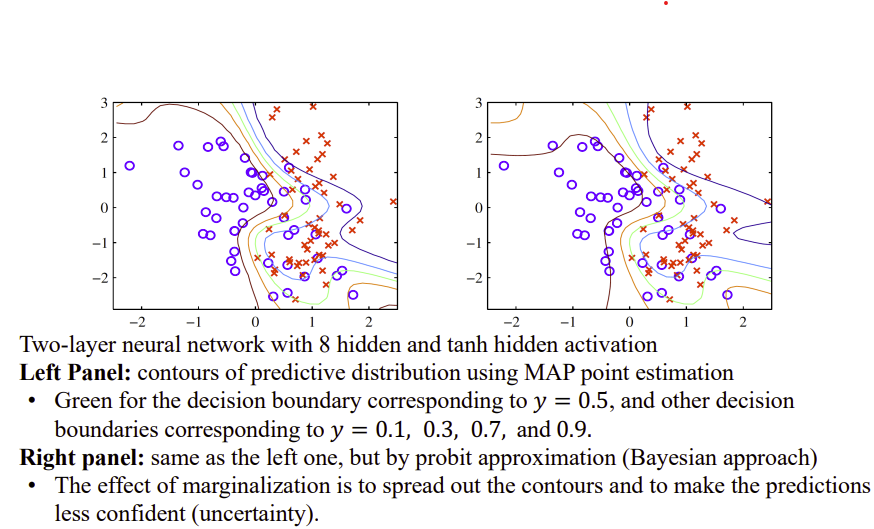

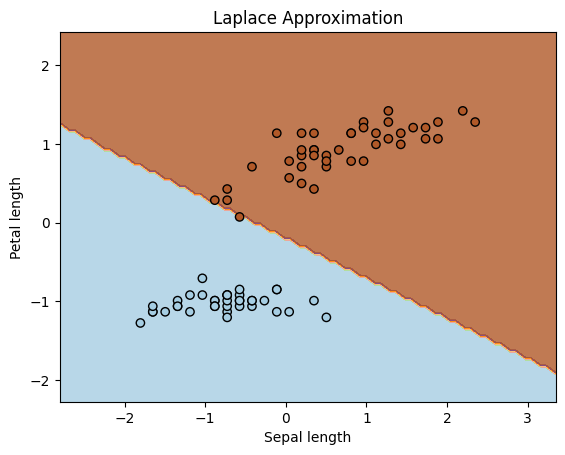

In [73]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.xlabel('Sepal length')
    plt.ylabel('Petal length')
    plt.title(title)
    plt.show()

# Laplace approximation
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

laplace_model = CalibratedClassifierCV(LogisticRegression(penalty='l2', C=0.1))
laplace_model.fit(X_train, y_train)

# Plot decision boundary for Laplace approximation
plot_decision_boundary(X_train, y_train, laplace_model, title='Laplace Approximation')

I'm going to leave this one in because it's really funny

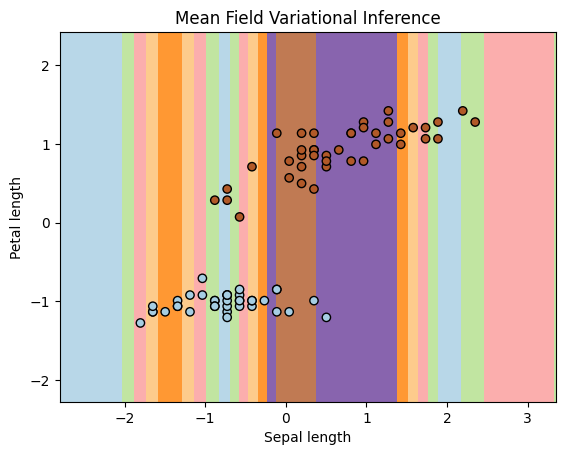

In [77]:
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = np.repeat(Z.reshape(1, -1), 10, axis=0)  # Repeat each row 10 times
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.xlabel('Sepal length')
    plt.ylabel('Petal length')
    plt.title(title)
    plt.show()

# Mean Field Variational Inference
mean_field_model = MeanFieldVariationalInference(n_features=2)
mean_field_model.fit(X_train, y_train)

# Plot decision boundary for Mean Field Variational Inference
plot_decision_boundary(X_train, y_train, mean_field_model, title='Mean Field Variational Inference')
